# <font style="font-family:roboto;color:#455e6c"> Data analysis and workflows in Materials science </font>  

## <font style="font-family:roboto;color:#455e6c"> Part II: Workflows in Materials Science </font>  

Now that we are familiar with python, we will look a typical workflow in materials science. We will calculate the Youngs modulus, first with [LAMMPS](https://www.lammps.org/#gsc.tab=0), a widely used simulation code. If you are looking for a quick way to calculate elastic constants, example script provided with LAMMPS is the way to go. Here, the method itself will be explored. [This method](http://micro.stanford.edu/wiki/M07_Computing_Elastic_Constants) will be followed here and is a good resource for further reading. 

A crucial input that we need is a way to model to the interaction between the atoms. Here will we will use an [Embedded Atom Method interatomic potential](https://www.tandfonline.com/doi/abs/10.1080/14786430802206482) to simulate Aluminium.

## Using Stress

For a cubic material, there are three independent elastic constants - $C_{11}$, $C_{12}$ and $C_{44}$. $C_{11}$ and $C_{12}$ can be calculated from the stress-strain relationships. If a strain $\epsilon_{11}$ is applied and the stresses $\sigma_{11}$ and $\sigma_{22}$ are measured, the elastic constants can be calculated directly from,

$$
C_{11} = \frac{\sigma_{11}}{\epsilon_{11}} \\
C_{12} = \frac{\sigma_{22}}{\epsilon_{11}}
$$

Here, we will focus on $C_{11}$, which is the Youngs Modulus.

The LAMMPS script is already prepared for you. Let us take a look first.

In [3]:
! cat lammps.in

#Set up the units, boundary
units                  metal 
dimension              3 
boundary               p p p 
atom_style             atomic

#Create a simulation box
lattice                fcc 4.045  
region                 box block 0 4 0 4 0 4
create_box             1 box
create_atoms           1 box

#specify the interatomic interaction
pair_style             eam/fs
pair_coeff             * * potentials/Al1.eam.fs Al

#relax the structure
fix                    1 all box/relax iso 0. vmax 0.0001 nreset 1
minimize               1.0e-8 1.0e-8 100000000 100000000

#tell LAMMPS what quantities to compute
compute                t all temp
compute                stress all pressure t

#apply strain on the system
fix                    strain all deform 1 x erate 0.00001
#print out stress
fix                    extra all print 1 " $(lx) ${sigma11} ${sigma22}" file stress.dat
#do 1000 times
run                    1000

Now we can run the script

In [7]:
! lmp_serial -in lammps.in

LAMMPS (23 Jun 2022 - Update 1)
Lattice spacing in x,y,z = 4.045 4.045 4.045
Created orthogonal box = (0 0 0) to (16.18 16.18 16.18)
  1 by 1 by 1 MPI processor grid
Created 256 atoms
  using lattice units in orthogonal box = (0 0 0) to (16.18 16.18 16.18)
  create_atoms CPU = 0.000 seconds
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.5
  ghost atom cutoff = 8.5
  binsize = 4.25, bins = 4 4 4
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/fs, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up cg style minimization ...
  Unit style    : metal
  Current step  : 0
Per MPI rank memory allocation (min/avg/max) = 4.536 | 4.536 | 4.536 Mbytes
   Step          Temp          E_pair         E_mol          TotEng         Press          Volume    
         0   0             -87

We can read in the output we need, from `stress.dat`

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
lx, sigma11, sigma22 = np.loadtxt("stress.dat", unpack=True)

The first thing to do to look at our data is to convert the simulation box dimension along x to strain. The value at position 0, `lx[0]` is the undeformed box dimension. Thus, the strain is given as,

In [12]:
strain = (lx -lx[0])/lx

Great! Now we can see the stress values that we calculated,

In [13]:
sigma11

array([ -0.02322934,  -0.02322934,  -0.03373851, ..., -10.5070929 ,
       -10.51761456, -10.52813623])

The first thing to notice is that the values are negative. Since we are calculating the pressure, the negative sign just indicates that the simulation box wants to contract. The values are in bar, so to convert to GPa, it is multiplied with 0.0001

In [14]:
sigma11 = -1*0.0001*sigma11
sigma22 = -1*0.0001*sigma22

Now we can plot the strain versus the stress.

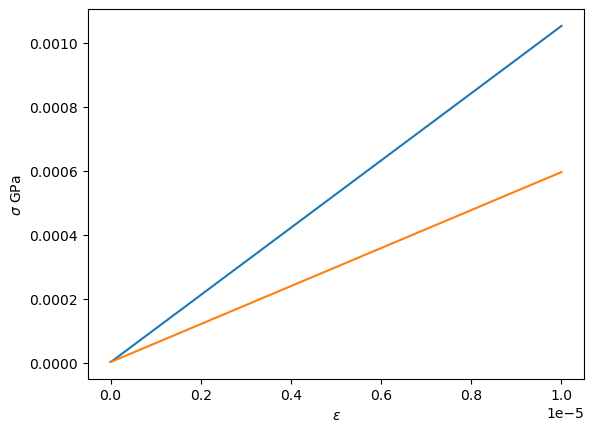

In [17]:
plt.plot(strain, sigma11, '-', label=r"$\sigma_{11}$")
plt.plot(strain, sigma22, '-', label=r"$\sigma_{22}$")
plt.xlabel(r"$\epsilon$");
plt.ylabel(r"$\sigma$ GPa");

The slope of $\sigma_{11}-\epsilon_{11}$ and $\sigma_{22}-\epsilon_{11}$ will give $C_{11}$ and $C_{12}$ respectively. To calculate the slope, we can fit a straight line using numpy. We can use the `polyfit` function for that. `polyfit` stands for polynomial fit, and we need to provide an order of fit.

In [18]:
np.polyfit(strain, sigma11, 1)

array([1.05154584e+02, 1.17015696e-06])

The function above fits it to $y = m*x + c$, the output is the slope, $m$ and the intercept $c$. Therefore the Youngs modulus is 105 GPa. The expected value would be 118 GPa, so our estimate is fairly close.

<div class="admonition note" name="html-admonition" style="background: #FFEDD1; padding: 10px">
<p class="title"><b>Task</b></p>
Calculate C12
</div>

We successfully managed to calculate the elastic constants. However, there were a number of things we had to do or know:

- How to write LAMMPS script
- Interatomic potential file

Additionally, we ran LAMMPS from the terminal, then took the results file, and post-processed it with python. These workflows come with a number of risks which affect the reproducibility. Also, how can we be sure that we ourselves can understand and interpret these calculations as time goes by. 

- We need to organise folders and files ourselves (possibly with a naming convention)
- We need to be able to look into the LAMMPS file and understand the input quantities.
- We need to save the python script for the analysis we did.
- ..

This is where workflow environments come in. Workflow environments automate a number of these tasks and make it easy for you to focus on the science. One such workflow environment in pyiron. Now we will do the same calculation using pyiron.

In [19]:
from pyiron import Project

The Project object introduced below is central in pyiron. You can imagine it to be equivalent to the current scientific project you are working on. In this case, we will call it `Al_elastic_constant`

In [21]:
project = Project("Al_elastic_constant")

The next major object in pyiron is `Job`. A Job is a class designed to do a particular task at hand. pyiron comes with a lot of pre-built jobs. However, it is also easy to create your own.

In this case we will use a job for calculating elastic constants. You can always press `Tab` key for autocompletion to see what options are possible. Now we create a LAMMPS job.

In [22]:
job = project.create.job.Lammps("job_1")

First thing we need is a structure! pyiron also provides tools to create and visualise structures.

In [27]:
structure = pr.create.structure.bulk('Al', cubic=True)

In [28]:
structure.plot3d()

NGLWidget()

We assign the structure to a job

In [29]:
job.structure = structure

Next thing we need is an interatomic potential. We can check which potentials are available.

In [33]:
job.list_potentials()

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1',
 '1999--Mishin-Y--Al--LAMMPS--ipr1',
 '2000--Landa-A--Al-Pb--LAMMPS--ipr1',
 '2000--Sturgeon-J-B--Al--LAMMPS--ipr1',
 '2002--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2003--Lee-B-J--Al--LAMMPS--ipr1',
 '2003--Zope-R-R--Al--LAMMPS--ipr1',
 '2003--Zope-R-R--Ti-Al--LAMMPS--ipr1',
 '2004--Liu-X-Y--Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr1',
 '2004--Mishin-Y--Ni-Al--LAMMPS--ipr2',
 '2004--Zhou-X-W--Al--LAMMPS--ipr2',
 '2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1',
 '2007--Silva-A-C--Al-Ni--LAMMPS--ipr1',
 '2008--Mendelev-M-I--Al--LAMMPS--ipr1',
 '2009--Kim-Y-M--Mg-Al--LAMMPS--ipr1',
 '2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
 '2009--Purja-Pun-G-P--Ni-Al--LAMMPS--ipr1',
 '2009--Zhakhovskii-V-V--Al--LAMMPS--ipr2',
 '2010--Lee-E--Fe-Al--LAMMPS--ipr1',
 '2010--Mendelev-M-I--fictional-Al-1--

There are a large number of potentials available for Al. We will select the same one as before. However, here we did not have to find the file, or consider how it is mapped into the LAMMPS input file.

In [34]:
job.potential = "2008--Mendelev-M-I--Al--LAMMPS--ipr1"

As we discussed before, the first step is a relaxation or minimization. We will do the same here.

In [35]:
job.calc_minimize()

Now we use the LAMMPS job as a reference, and now tell pyiron to calculate the elastic constants.

In [36]:
elastic_job = job.create_job(pr.job_type.ElasticMatrixJob, "elastic_job")

We provide the input strain range, 0.001

In [37]:
elastic_job.input["eps_range"] = 0.001

And finally call run

In [40]:
elastic_job.run()

The job elastic_job was saved and received the ID: 2
The job s_e_0 was saved and received the ID: 3
The job s_01_e_m0_00100 was saved and received the ID: 4
The job s_01_e_m0_00050 was saved and received the ID: 5
The job s_01_e_0_00050 was saved and received the ID: 6
The job s_01_e_0_00100 was saved and received the ID: 7
The job s_08_e_m0_00100 was saved and received the ID: 8
The job s_08_e_m0_00050 was saved and received the ID: 9
The job s_08_e_0_00050 was saved and received the ID: 10
The job s_08_e_0_00100 was saved and received the ID: 11
The job s_23_e_m0_00100 was saved and received the ID: 12
The job s_23_e_m0_00050 was saved and received the ID: 13
The job s_23_e_0_00050 was saved and received the ID: 14
The job s_23_e_0_00100 was saved and received the ID: 15


The `elastic_job` starts several other jobs automatically. Once it is finished, we can look at the results.

In [42]:
elastic_job["output/elasticmatrix"]["C"][0,0]

106.19433768871819

You can see that we got very similar results. However, we could directly focus on the scientific aspects of the workflow. pyiron takes care of managing the folders, giving IDs to your jobs, and the post-processing automatically

### Further reading

- [Calculation of elastic constants](http://micro.stanford.edu/wiki/M07_Computing_Elastic_Constants)
- [LAMMPS documentation](https://lammps.sandia.gov/doc/Manual.html)
- [EAM potential used in this notebook](https://www.tandfonline.com/doi/abs/10.1080/14786430802206482)
- [pyiron](https://pyiron.org)